# Regresión lineal: predecir los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos. 


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [2]:
# Lo instalamos en nuestro ambiente local, en este caso trabajo en una ambiente de conda
# para instalarlo ejecutamos las siguientes lineas de codigo en el ambiente seleccionado:
# pip install --upgrade pip setuptools==57.5.0
# pip install regressors

In [3]:
# librerias
import pandas as pd
import seaborn as sns

In [4]:
# Estilos de las graficas
sns.set(style='whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [5]:
df = pd.read_csv('./insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

In [6]:
# dimension del dataframe
print(df.shape)

(1338, 7)


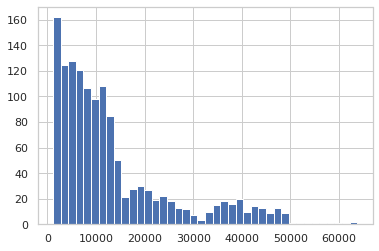

In [7]:
# Histograma de la variable objetivo (charges)
df.charges.hist(bins=40);

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [8]:
df[df.charges > 50000]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio. 

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

In [9]:
# df con solo cargos menores a 50000
df = df[df.charges < 50000]

Vamos a crear una funcion que detecte valores atipicos en las variables

In [28]:
def detect_outliers(x):
    
    Q3 = df[x].quantile(0.75)
    Q1 = df[x].quantile(0.25)
    IQR = Q3 - Q1
    
    superior = Q3 + (1.5 * IQR)
    inferior = Q3 - (1.5 * IQR)

    out_sup = df[df[x] > superior].index
    out_inf = df[df[x] < inferior].index

    outliers = []
    for i in out_sup:
        outliers.append(i)
    for j in out_sup:
        outliers.append(j)

    size = len(outliers)

    return (f'Hay {size} valores atipicos en la variable {x} cuyos indices son: {outliers}')

Probamos la funcion en la variable **bmi**

In [29]:
detect_outliers('bmi')

'Hay 16 valores atipicos en la variable bmi cuyos indices son: [116, 286, 401, 847, 860, 1047, 1088, 1317, 116, 286, 401, 847, 860, 1047, 1088, 1317]'

Verifiquemos que sean correctas los resultados de la funcion mediante el histograma de **bmi**

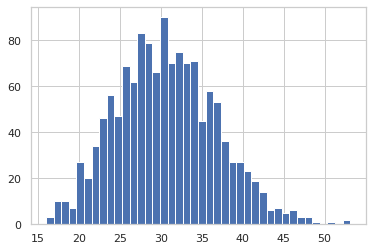

In [21]:
df.bmi.hist(bins=40);

Vemos que los valores de bmi mayores a 50 tienden a ser valores atipicos.

In [22]:
df[df['bmi'] > 50]

,age,sex,bmi,children,smoker,region,charges
847,23,male,50.38,1,no,southeast,2438.0552
1047,22,male,52.58,1,yes,southeast,44501.3982
1317,18,male,53.13,0,no,southeast,1163.4627


## Viendo correlaciones
Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan. 

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función get_dummies de pandas. 

Ahora la verás en acción

## Creando modelos 
Primero se usará un modelo con todas las variables.

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

El siguiente código muestra un resumen general de los resultados.

Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

Analizando el segundo modelo